In [38]:
import numpy as np
%matplotlib inline
import Corrfunc
import glob
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

import utils
import plotter
import bao_utils

%load_ext autoreload
%autoreload 2

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize}
pylab.rcParams.update(params)

import cmasher as cmr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
def load_data(cat_tag, cf_tag, Nrealizations=100, return_amps=False):
    
    cat_dir = '../catalogs'
    result_dir = '../results/results_lognormal{}'.format(cat_tag)

    rs = []
    xis = []
    amps = []
    n_converged = 0

    for Nr in range(Nrealizations):

        if 'baoiter' in cf_tag:
            fn_pattern = f"cf{cf_tag}_converged_*{cat_tag}_rlz{Nr}.npy"
            matches = glob.glob(f'{result_dir}/{fn_pattern}')
            for cf_fn in matches:
                r_avg, xi, amp, _, _ = np.load(cf_fn, allow_pickle=True)
                n_converged +=1
                break #should only be 1 match; but probs better way to do this
            if len(matches)==0:
                continue
        else:
            cf_fn = '{}/cf{}{}_rlz{}.npy'.format(result_dir, cf_tag, cat_tag, Nr)
            r_avg, xi, amps, proj, extra = np.load(cf_fn, allow_pickle=True)
        rs.append(r_avg)
        xis.append(xi)
        amps.append(amp)
        
    if 'baoiter' in cf_tag:
        print(f'Number converged: {n_converged}/{Nrealizations}')
        
    if return_amps:
        return rs, xis, amps
    else:
        return rs, xis

In [3]:
def plot_cf_err(rs, cf_arrs, r_true, cf_true, labels, colors, err=False, xlim=None, errlim=None, cont=True, bases=None):
    
    if np.array(rs).ndim == 1:
        rs = [rs]
    if np.array(cf_arrs).ndim == 2:
        cf_arrs = np.array([cf_arrs])
    
    cfs_mean = []
    error_regions = []
    for cfs in cf_arrs:
        mean = np.mean(cfs, axis=0)
        cfs_mean.append(mean)
        std = np.std(cfs, axis=0)
        error_regions.append([mean-std, mean+std])
    
    ax = plotter.plot_cf_cont(rs, cfs_mean, r_true, cf_true, labels, colors, error_regions=error_regions, 
                         err=err, xlim=xlim, errlim=errlim, cont=cont, bases=bases)
    return ax

In [34]:
def plot_continuous(cat_tag, cf_tags, Nrealizations=100, colors=None, labels=None, err=True, errlim=None, 
                    cont=True, show_bases=True, xlim=None, peak_fit=False, bws=[], r_widths=[], r_max_true=None, b1=2.0):
    
    if colors is None:
        colors = ['lime','blue', 'cyan', 'magenta', 'purple']
    if labels is None:
        labels = [f"{tag.split('_')[1]}, bin width {tag.split('bw')[-1]}" for tag in cf_tags]
    if xlim is None:
        xlim = [40.0, 148.0]
    
    cat_dir = '../catalogs'
    result_dir = '../results/results_lognormal{}'.format(cat_tag)

    rs = []
    r_arrs = []
    cf_arrs = []
    if show_bases:
        bases = []

    for i in range(len(cf_tags)):
        cf_tag = cf_tags[i]
        xis = []
        rarr = []
        n_converged = 0

        rarr, xis = load_data(cat_tag, cf_tag, Nrealizations=Nrealizations, return_amps=False)
        #rarr.append(r_avg)
        #xis.append(xi)
        r_avg = rarr[0]
        rs.append(r_avg)
        r_arrs.append(rarr)
        cf_arrs.append(xis)     

        if show_bases:
            if 'tophat' in cf_tag:
                rmin = min(r_avg)
                rmax = max(r_avg)
                binwidth = float(cf_tag.split('bw')[-1])
                r_edges = np.arange(rmin, rmax+binwidth, binwidth)
                base = np.zeros((len(r_avg), len(r_edges))) #r_edges - 1 (bc edges not bins), +1 (bc ravg)
                base[:,0] = r_avg
                for rr in range(len(r_edges)-1):
                    base[:,rr+1] = [1.0 if r_edges[rr]<=r_avg[jj]<r_edges[rr+1] else 0.0 for jj in range(len(r_avg))]
            else:
                if 'baoiter' in cf_tag:
                    rmin, rmax = 36.0, 200.0
                    redshift = 0.57
                    bias = 2.0
                    projfn = f'../tables/bases{cf_tag}_r{rmin}-{rmax}_z{redshift}_bias{bias}.dat'
                else:
                    projfn = f'../tables/bases{cf_tag}.dat'
                base = np.loadtxt(projfn)
                bmax = max(np.array([base[bb,1:] for bb in range(base.shape[0]) if xlim[0]<base[bb,0]<xlim[1]]).flatten())
                base[:,1:] /= bmax   
            bases.append(base)        
        
    true_fn = '{}/inputs/cat{}_Rh_xi.txt'.format(cat_dir, cat_tag)
    r_true, xi_true = np.loadtxt(true_fn, unpack=True)
    xi_true *= b1**2

    ax = plot_cf_err(rs, cf_arrs, r_true, xi_true, labels, colors, err=err, xlim=xlim, 
                errlim=errlim, cont=cont, bases=bases)
    
    if peak_fit:
        r_peak_guess = 100.0
        r_peak_arr, *_ = find_peaks_center(r_arrs, cf_arrs, r_peak_guess, bws=bws, r_widths=r_widths)
        for i in range(len(cf_tags)):
            r_med = np.nanmedian(r_peak_arr[i])
            r_p16 = np.nanpercentile(r_peak_arr[i], 16)
            r_p84 = np.nanpercentile(r_peak_arr[i], 84)
            ax[0].errorbar(r_med, 0.008+i*0.001, xerr=[[r_med-r_p16], [r_p84-r_med]], fmt='o', 
                           color=colors[i], markersize=4)
        if r_max_true is not None:
            ax[0].errorbar(r_max_true, 0.008-0.001, fmt='o', color='k', markersize=4)
        return ax, r_peak_arr
    else:
        return ax

In [5]:
ctopmany = '#33BBEE'
ctopmid = '#3547F1'
ctopfew = '#0077BB'
cspline = '#EE3377'
cbao = '#228833'
ctheory = '#808080'

(2, 1000)
rmse: True
plotting
0.0010186 100000.0


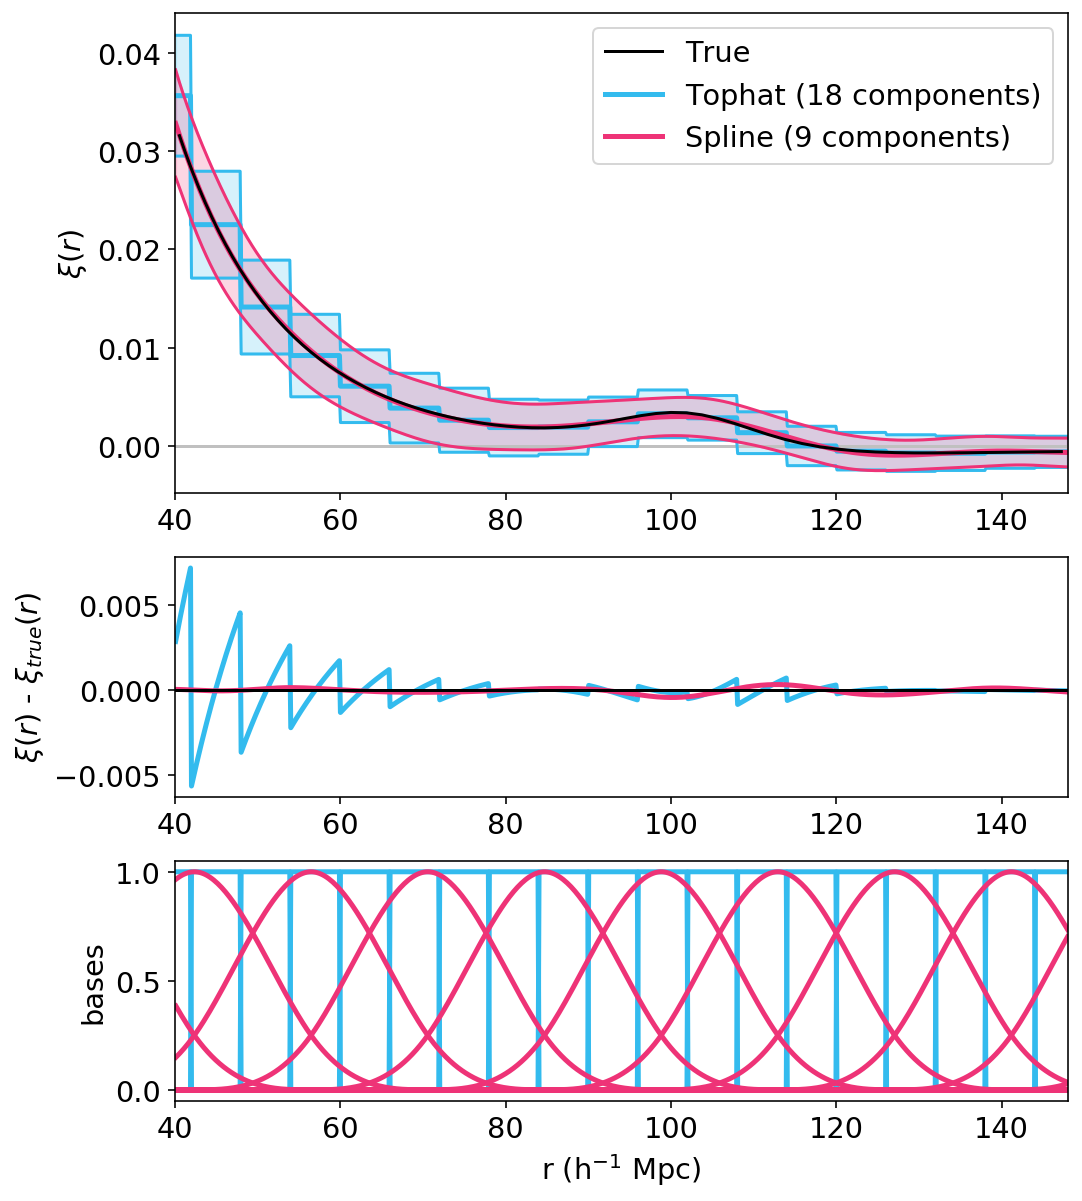

In [15]:
cat_tag = '_L750_n5e-5_z057'
cf_tags = ['_tophat_bw6', '_spline3_bw12']
colors = [ctopmany, cspline]
labels = ['Tophat (18 components)', 'Spline (9 components)']

ax = plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, peak_fit=False, Nrealizations=1000)

(2, 1000)
rmse: True
plotting
0.0010186 100000.0


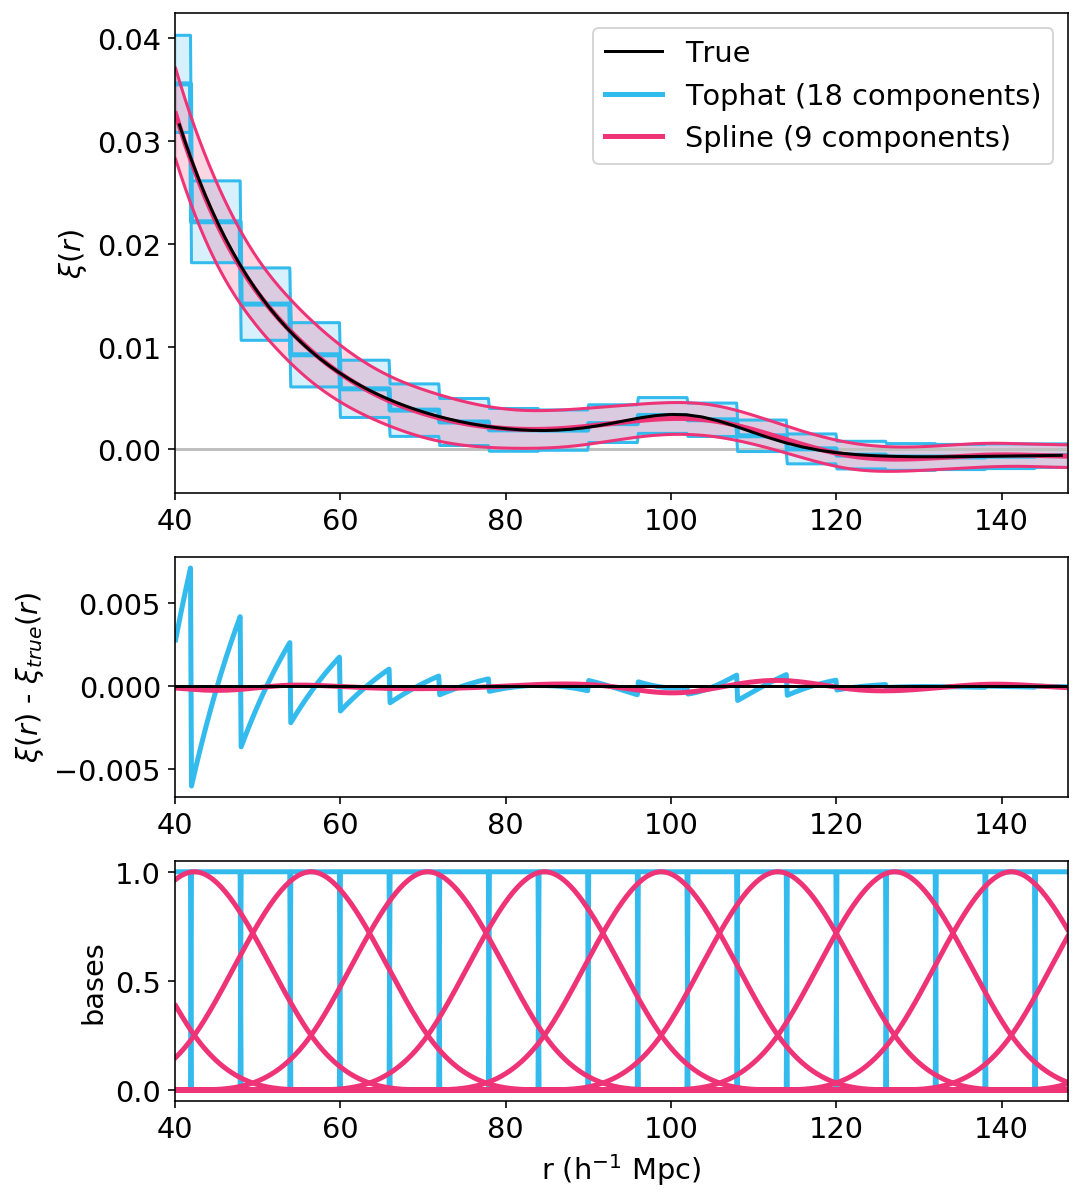

In [18]:
cat_tag = '_L750_n1e-4_z057'
cf_tags = ['_tophat_bw6', '_spline3_bw12']
colors = [ctopmany, cspline]
labels = ['Tophat (18 components)', 'Spline (9 components)']

ax = plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, peak_fit=False, Nrealizations=1000)

(2, 1000)
rmse: True
plotting
0.0010186 100000.0


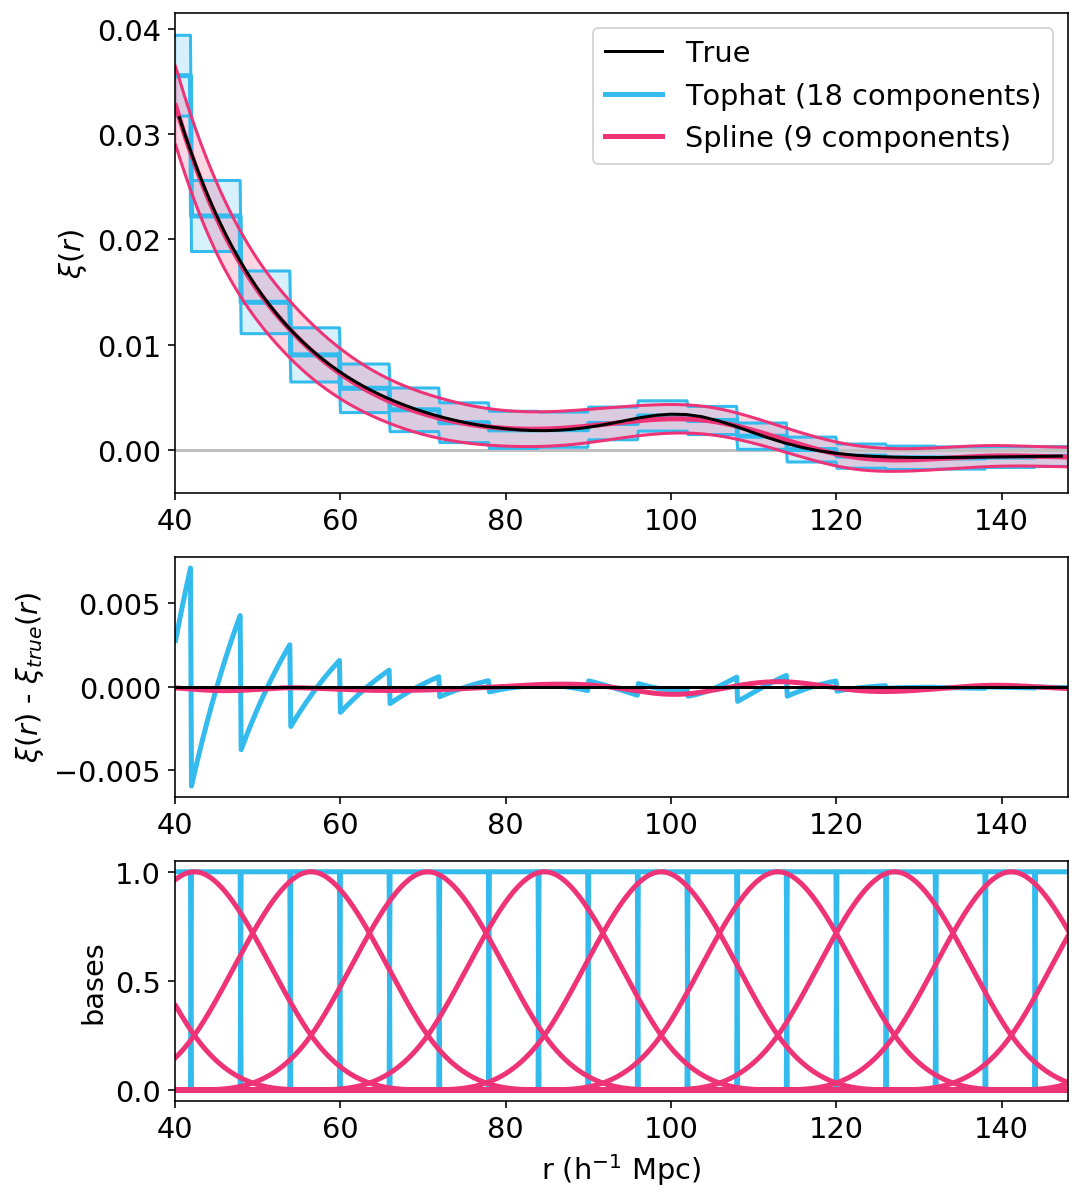

In [19]:
cat_tag = '_L750_n2e-4_z057'
cf_tags = ['_tophat_bw6', '_spline3_bw12']
colors = [ctopmany, cspline]
labels = ['Tophat (18 components)', 'Spline (9 components)']

ax = plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, peak_fit=False, Nrealizations=1000)

(3, 1000)
rmse: True
plotting
0.0010186 100000.0


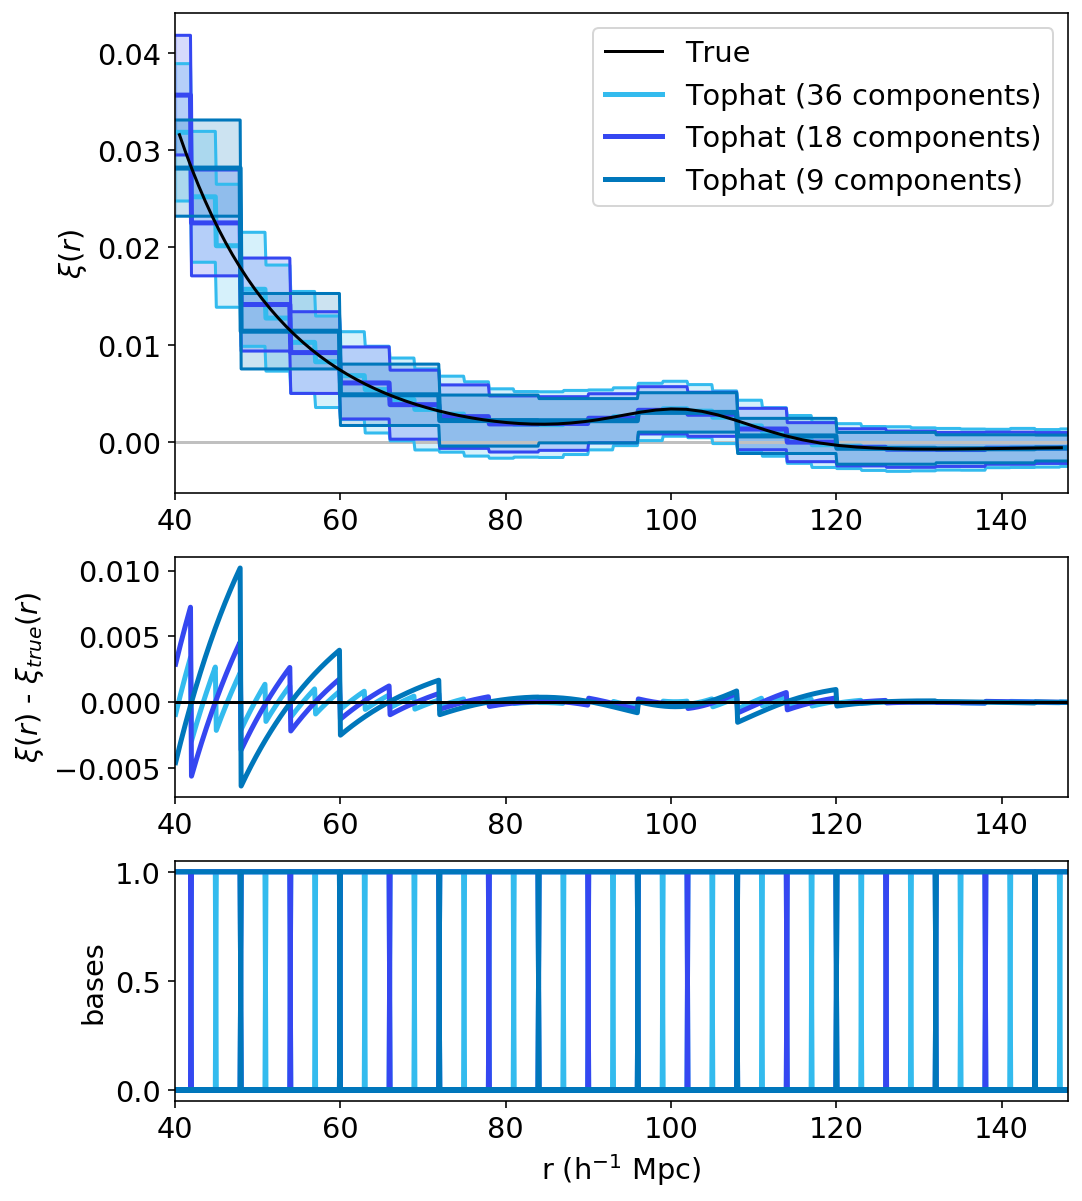

In [23]:
cat_tag = '_L750_n5e-5_z057'
cf_tags = ['_tophat_bw3', '_tophat_bw6', '_tophat_bw12']
colors = [ctopmany, ctopmid, ctopfew]
labels = ['Tophat (36 components)', 'Tophat (18 components)', 'Tophat (9 components)']

ax = plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, peak_fit=False, Nrealizations=1000)

## BAO 

What is alpha supposed to be?

In [46]:
import nbodykit

#Params for assumed cosmology for BAO basis
Omega0_cdm = 0.31
Omega0_b = 0.04814
h0 = 0.676
ns = 0.96
cosmo_b17 = nbodykit.cosmology.Cosmology(h=h0, Omega0_b=Omega0_b, Omega0_cdm=Omega0_cdm, n_s=ns)

#Params used to generate lognormal (Planck)
oc0h2 = 0.11880 # \Omega_c h^2
mnu = 0.00   # \Sigma m_{\nu} total neutrino mass
ns = 0.9667
lnAs = 3.064
ob0h2 = 0.02230 #\Omega_baryon h^2
h0 = 0.6774 # H0/100
w = -1.0
run = 0.0 # running index pf pk
m_ncdm = [] #pass empty list for no massive neutrinos
Omega0_b = ob0h2 / h0**2
Omega0_cdm = oc0h2 / h0**2
cosmo_planck = nbodykit.cosmology.Cosmology(h=h0, Omega0_b=Omega0_b, Omega0_cdm=Omega0_cdm, 
                                            m_ncdm=m_ncdm, n_s=ns)

z = 0.57
alpha_true = bao_utils.compute_alpha(z, cosmo_planck, cosmo_b17) #1st is truth, 2nd is fiducial

Cosmo: r_s: 158.26595003520382 D_A: 1386.683612636117 Mpc H: 92.95294554563436 km / (Mpc s)
Fiducial: r_s: 151.6335957884925 D_A: 1362.8322033846473 Mpc H: 96.36955022372915 km / (Mpc s)
alpha: 0.9809725024612357


Number converged: 55/100
(1, 1000)
rmse: True
plotting
0.0010186 100000.0


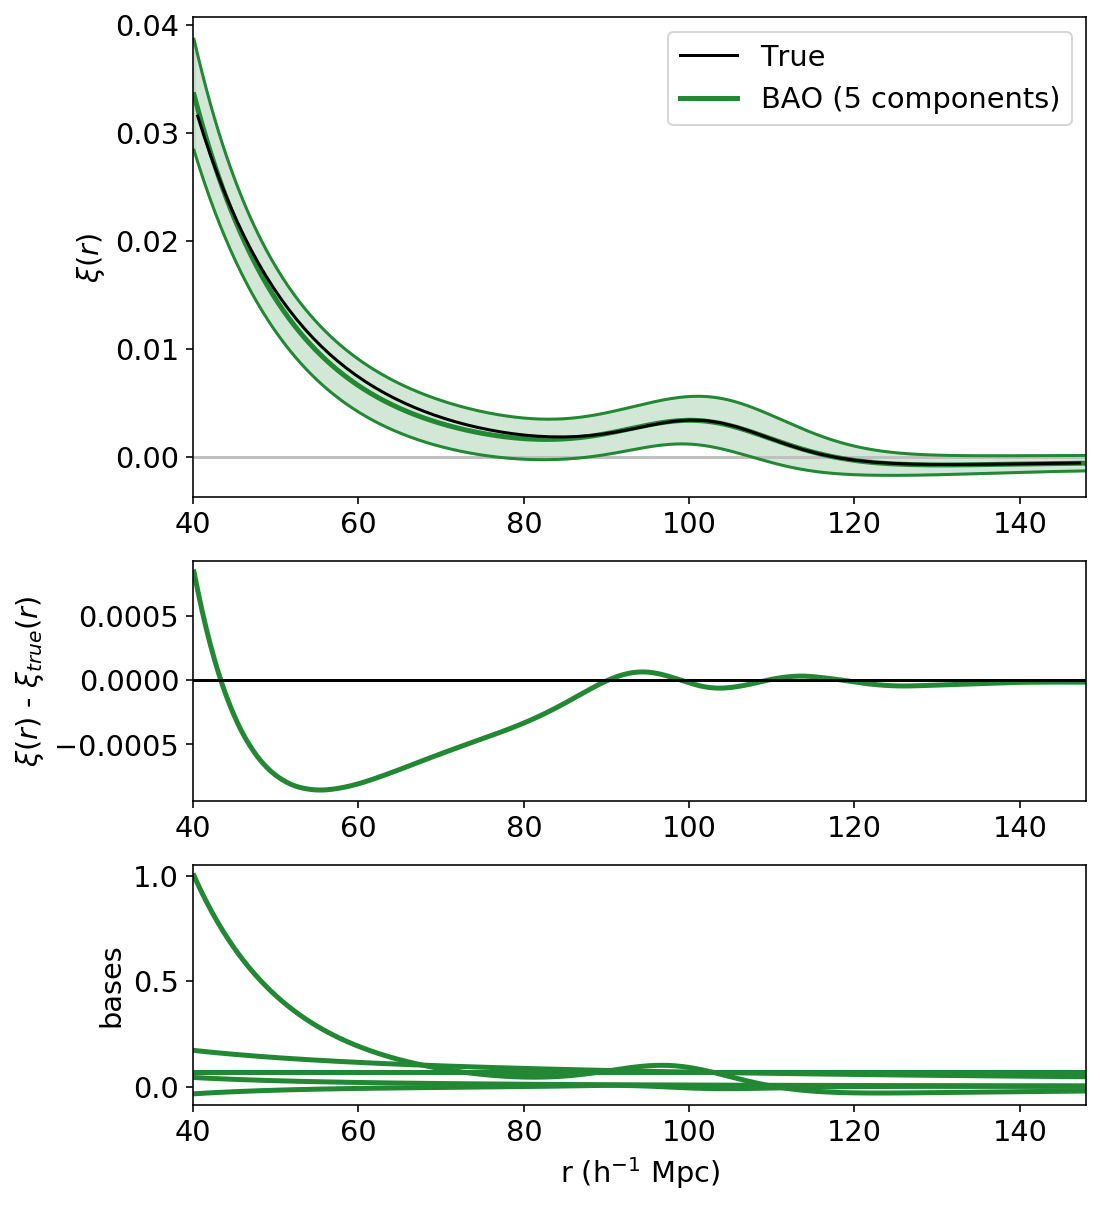

In [35]:
cat_tag = '_L750_n5e-5_z057'
cf_tags = ['_baoiter_cosmob17']
colors = [cbao]
labels = ['BAO (5 components)']

ax = plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, peak_fit=False, Nrealizations=100)

In [42]:
cat_tag = '_L750_n5e-5_z057'
cf_tag = '_baoiter_cosmob17'
alphas = bao_utils.calc_alpha(cat_tag, cf_tag, realizations=range(100))

_baoiter_cosmob17
Found 55 converged BAO cfs (45 not converged)
alpha_mean: 0.9672868648117188
alpha_std: 0.03700742358766399


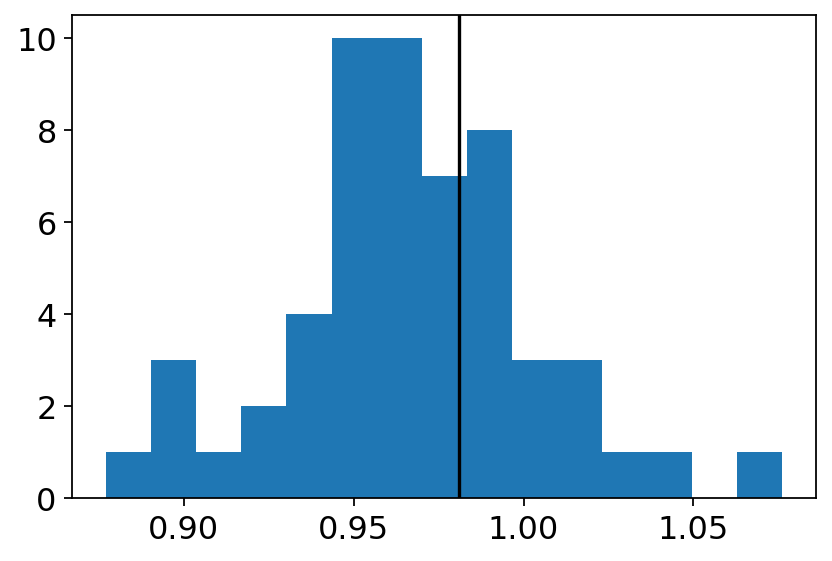

In [47]:
plt.hist(alphas, bins=15)
plt.axvline(alpha_true, color='black')